Importing Libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.spatial.distance import cosine
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Utility libraries
import pickle
import re
import streamlit as st
from collections import defaultdict
import random

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

print("All libraries imported successfully!")

All libraries imported successfully!


Data Pre-Processing

In [3]:
def load_and_preprocess_data():
    """Load and preprocess the Goodbooks-10k dataset"""
    
    # Load datasets
    books = pd.read_csv(r'D:\infotact\Project 2\books.csv')
    ratings = pd.read_csv(r'D:\infotact\Project 2\ratings.csv')
    book_tags = pd.read_csv(r'D:\infotact\Project 2\book_tags.csv')
    tags = pd.read_csv(r'D:\infotact\Project 2\tags.csv')
    
    print(f"Books shape: {books.shape}")
    print(f"Ratings shape: {ratings.shape}")
    print(f"Book tags shape: {book_tags.shape}")
    print(f"Tags shape: {tags.shape}")
    
    # Clean books data
    books['authors'] = books['authors'].fillna('Unknown')
    books['title'] = books['title'].fillna('Unknown Title')
    books['original_publication_year'] = books['original_publication_year'].fillna(
        books['original_publication_year'].median()
    )
    
    # Create combined features for content-based filtering
    books['combined_features'] = (
        books['authors'].astype(str) + ' ' + 
        books['title'].astype(str) + ' ' +
        books['original_publication_year'].astype(str)
    )
    
    # Filter ratings to reduce computational load (keep users with at least 5 ratings)
    user_counts = ratings['user_id'].value_counts()
    active_users = user_counts[user_counts >= 5].index
    ratings_filtered = ratings[ratings['user_id'].isin(active_users)]
    
    # Keep books with at least 3 ratings
    book_counts = ratings_filtered['book_id'].value_counts()
    popular_books = book_counts[book_counts >= 3].index
    ratings_filtered = ratings_filtered[ratings_filtered['book_id'].isin(popular_books)]
    
    print(f"Filtered ratings shape: {ratings_filtered.shape}")
    
    # Merge tags data
    book_tags_merged = book_tags.merge(tags, on='tag_id')
    book_tags_grouped = book_tags_merged.groupby('goodreads_book_id')['tag_name'].apply(
        lambda x: ' '.join(x.astype(str))
    ).reset_index()
    book_tags_grouped.columns = ['book_id', 'tags']
    
    # Merge with books
    books_enhanced = books.merge(book_tags_grouped, left_on='book_id', right_on='book_id', how='left')
    books_enhanced['tags'] = books_enhanced['tags'].fillna('')
    
    # Update combined features with tags
    books_enhanced['combined_features'] = (
        books_enhanced['combined_features'] + ' ' + books_enhanced['tags']
    )
    
    return books_enhanced, ratings_filtered, book_tags_merged

# Load data
books_df, ratings_df, book_tags_df = load_and_preprocess_data()
print("Data preprocessing completed!")

Books shape: (10000, 23)
Ratings shape: (981756, 3)
Book tags shape: (999912, 3)
Tags shape: (34252, 2)
Filtered ratings shape: (932940, 3)
Data preprocessing completed!


EDA + Visualizations

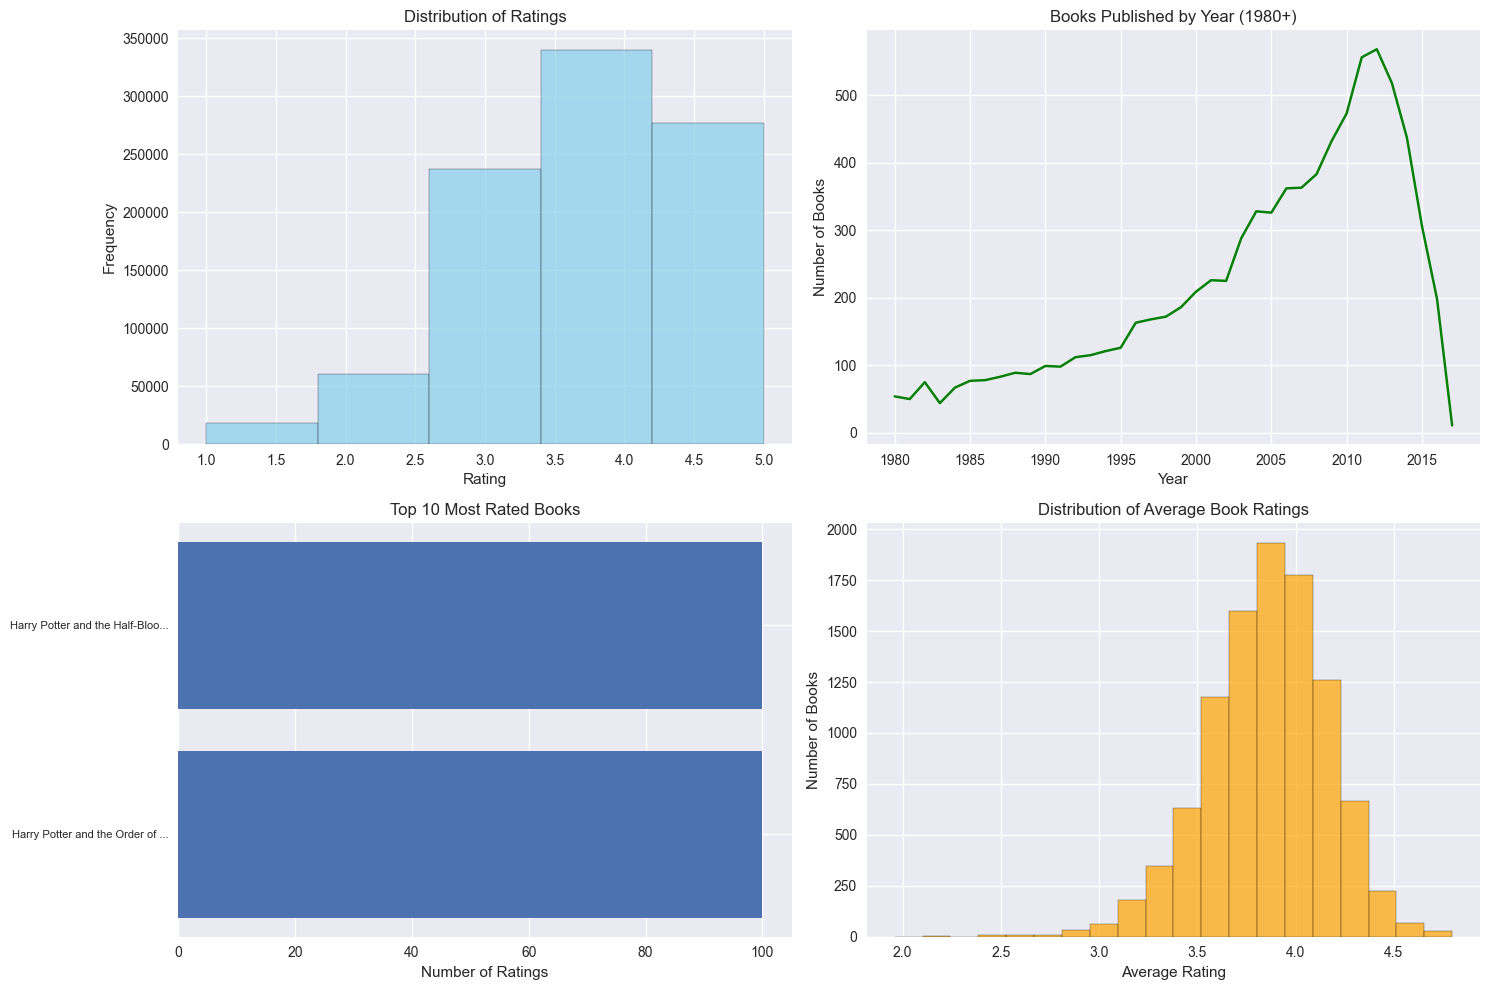


=== DATASET SUMMARY ===
Total books: 10000
Total ratings: 932940
Total users: 35710
Average rating: 3.85
Rating sparsity: 99.74%


In [4]:
def perform_eda(books_df, ratings_df):
    """Perform exploratory data analysis"""
    
    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Rating distribution
    axes[0,0].hist(ratings_df['rating'], bins=5, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title('Distribution of Ratings')
    axes[0,0].set_xlabel('Rating')
    axes[0,0].set_ylabel('Frequency')
    
    # 2. Books per year
    year_counts = books_df['original_publication_year'].value_counts().sort_index()
    year_counts_recent = year_counts[year_counts.index >= 1980]
    axes[0,1].plot(year_counts_recent.index, year_counts_recent.values, color='green')
    axes[0,1].set_title('Books Published by Year (1980+)')
    axes[0,1].set_xlabel('Year')
    axes[0,1].set_ylabel('Number of Books')
    
    # 3. Top 10 most rated books
    book_rating_counts = ratings_df['book_id'].value_counts().head(10)
    top_books = books_df[books_df['book_id'].isin(book_rating_counts.index)]
    top_books_merged = top_books.merge(
        book_rating_counts.to_frame('rating_count'), 
        left_on='book_id', right_index=True
    )
    
    axes[1,0].barh(range(len(top_books_merged)), top_books_merged['rating_count'])
    axes[1,0].set_yticks(range(len(top_books_merged)))
    axes[1,0].set_yticklabels([title[:30] + '...' if len(title) > 30 else title 
                              for title in top_books_merged['title']], fontsize=8)
    axes[1,0].set_title('Top 10 Most Rated Books')
    axes[1,0].set_xlabel('Number of Ratings')
    
    # 4. Average rating distribution
    book_avg_ratings = ratings_df.groupby('book_id')['rating'].mean()
    axes[1,1].hist(book_avg_ratings, bins=20, alpha=0.7, color='orange', edgecolor='black')
    axes[1,1].set_title('Distribution of Average Book Ratings')
    axes[1,1].set_xlabel('Average Rating')
    axes[1,1].set_ylabel('Number of Books')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n=== DATASET SUMMARY ===")
    print(f"Total books: {len(books_df)}")
    print(f"Total ratings: {len(ratings_df)}")
    print(f"Total users: {ratings_df['user_id'].nunique()}")
    print(f"Average rating: {ratings_df['rating'].mean():.2f}")
    print(f"Rating sparsity: {(1 - len(ratings_df) / (ratings_df['user_id'].nunique() * ratings_df['book_id'].nunique())) * 100:.2f}%")

# Perform EDA
perform_eda(books_df, ratings_df)

Collaborative Filtering SVD

In [5]:
class CollaborativeFilteringSVD:
    def __init__(self, n_components=50):
        self.n_components = n_components
        self.svd = TruncatedSVD(n_components=n_components, random_state=42)
        self.user_item_matrix = None
        self.user_mapping = {}
        self.item_mapping = {}
        self.reverse_user_mapping = {}
        self.reverse_item_mapping = {}
        
    def prepare_matrix(self, ratings_df):
        """Prepare user-item matrix"""
        # Create mappings
        unique_users = ratings_df['user_id'].unique()
        unique_items = ratings_df['book_id'].unique()
        
        self.user_mapping = {user: idx for idx, user in enumerate(unique_users)}
        self.item_mapping = {item: idx for idx, item in enumerate(unique_items)}
        self.reverse_user_mapping = {idx: user for user, idx in self.user_mapping.items()}
        self.reverse_item_mapping = {idx: item for item, idx in self.item_mapping.items()}
        
        # Create matrix
        n_users = len(unique_users)
        n_items = len(unique_items)
        
        user_item_matrix = np.zeros((n_users, n_items))
        
        for _, row in ratings_df.iterrows():
            user_idx = self.user_mapping[row['user_id']]
            item_idx = self.item_mapping[row['book_id']]
            user_item_matrix[user_idx, item_idx] = row['rating']
        
        self.user_item_matrix = user_item_matrix
        return user_item_matrix
    
    def fit(self, ratings_df):
        """Fit the SVD model"""
        print("Preparing user-item matrix...")
        matrix = self.prepare_matrix(ratings_df)
        
        print("Fitting SVD model...")
        self.svd.fit(matrix)
        
        print(f"SVD model fitted with {self.n_components} components")
        print(f"Explained variance ratio: {self.svd.explained_variance_ratio_.sum():.3f}")
        
    def predict_rating(self, user_id, book_id):
        """Predict rating for a user-book pair"""
        if user_id not in self.user_mapping or book_id not in self.item_mapping:
            return 3.0  # Default rating
        
        user_idx = self.user_mapping[user_id]
        item_idx = self.item_mapping[book_id]
        
        user_factors = self.svd.transform(self.user_item_matrix[user_idx:user_idx+1])
        item_factors = self.svd.components_[:, item_idx]
        
        predicted_rating = np.dot(user_factors[0], item_factors)
        return max(1, min(5, predicted_rating))
    
    def recommend_books(self, user_id, books_df, n_recommendations=10):
        """Recommend books for a user"""
        if user_id not in self.user_mapping:
            # Return popular books for new users
            popular_books = books_df.sample(n_recommendations)
            return popular_books[['book_id', 'title', 'authors']].to_dict('records')
        
        user_idx = self.user_mapping[user_id]
        user_ratings = self.user_item_matrix[user_idx]
        unrated_books = np.where(user_ratings == 0)[0]
        
        predictions = []
        for item_idx in unrated_books:
            book_id = self.reverse_item_mapping[item_idx]
            pred_rating = self.predict_rating(user_id, book_id)
            predictions.append((book_id, pred_rating))
        
        # Sort by predicted rating
        predictions.sort(key=lambda x: x[1], reverse=True)
        top_book_ids = [book_id for book_id, _ in predictions[:n_recommendations]]
        
        recommended_books = books_df[books_df['book_id'].isin(top_book_ids)]
        return recommended_books[['book_id', 'title', 'authors']].to_dict('records')

# Initialize and train collaborative filtering model
cf_model = CollaborativeFilteringSVD(n_components=30)  # Reduced for performance
cf_model.fit(ratings_df)
print("Collaborative filtering model trained!")

Preparing user-item matrix...
Fitting SVD model...
SVD model fitted with 30 components
Explained variance ratio: 0.076
Collaborative filtering model trained!


CONTENT BASES FILTERING (TF IDF)

In [6]:
class ContentBasedFiltering:
    def __init__(self, max_features=1000):  # Reduced for performance
        self.max_features = max_features
        self.tfidf = TfidfVectorizer(
            max_features=max_features,
            stop_words='english',
            lowercase=True,
            ngram_range=(1, 2)
        )
        self.tfidf_matrix = None
        self.books_df = None
        
    def fit(self, books_df):
        """Fit the TF-IDF model"""
        self.books_df = books_df.copy()
        
        print("Fitting TF-IDF model...")
        self.tfidf_matrix = self.tfidf.fit_transform(books_df['combined_features'].fillna(''))
        
        print(f"TF-IDF matrix shape: {self.tfidf_matrix.shape}")
        
    def get_similar_books(self, book_id, n_recommendations=10):
        """Get similar books based on content"""
        try:
            book_idx = self.books_df[self.books_df['book_id'] == book_id].index[0]
        except IndexError:
            return []
        
        # Calculate cosine similarity
        book_vector = self.tfidf_matrix[book_idx]
        similarities = linear_kernel(book_vector, self.tfidf_matrix).flatten()
        
        # Get top similar books (excluding the book itself)
        similar_indices = similarities.argsort()[::-1][1:n_recommendations+1]
        
        similar_books = self.books_df.iloc[similar_indices]
        return similar_books[['book_id', 'title', 'authors']].to_dict('records')
    
    def recommend_by_tags(self, tags, n_recommendations=10):
        """Recommend books based on tags"""
        tag_vector = self.tfidf.transform([tags])
        similarities = linear_kernel(tag_vector, self.tfidf_matrix).flatten()
        
        top_indices = similarities.argsort()[::-1][:n_recommendations]
        recommended_books = self.books_df.iloc[top_indices]
        
        return recommended_books[['book_id', 'title', 'authors', 'tags']].to_dict('records')

# Initialize and train content-based filtering model
cb_model = ContentBasedFiltering(max_features=800)  # Reduced for performance
cb_model.fit(books_df)
print("Content-based filtering model trained!")

Fitting TF-IDF model...
TF-IDF matrix shape: (10000, 800)
Content-based filtering model trained!


HYBRID MODEL

In [7]:
class HybridRecommenderSystem:
    def __init__(self, cf_model, cb_model, cf_weight=0.6, cb_weight=0.4):
        self.cf_model = cf_model
        self.cb_model = cb_model
        self.cf_weight = cf_weight
        self.cb_weight = cb_weight
        
    def recommend_books(self, user_id=None, book_id=None, tags=None, n_recommendations=10):
        """Hybrid recommendation combining collaborative and content-based filtering"""
        recommendations = []
        
        # Collaborative filtering recommendations
        if user_id and user_id in self.cf_model.user_mapping:
            cf_recs = self.cf_model.recommend_books(user_id, books_df, n_recommendations * 2)
            for rec in cf_recs:
                rec['source'] = 'collaborative'
                rec['score'] = self.cf_weight
            recommendations.extend(cf_recs)
        
        # Content-based recommendations
        if book_id:
            cb_recs = self.cb_model.get_similar_books(book_id, n_recommendations)
            for rec in cb_recs:
                rec['source'] = 'content_based'
                rec['score'] = self.cb_weight
            recommendations.extend(cb_recs)
        
        # Tag-based recommendations
        if tags:
            tag_recs = self.cb_model.recommend_by_tags(tags, n_recommendations)
            for rec in tag_recs:
                rec['source'] = 'tag_based'
                rec['score'] = self.cb_weight * 0.8
            recommendations.extend(tag_recs)
        
        # Remove duplicates and combine scores
        book_scores = defaultdict(float)
        book_info = {}
        
        for rec in recommendations:
            book_id = rec['book_id']
            book_scores[book_id] += rec['score']
            if book_id not in book_info:
                book_info[book_id] = rec
        
        # Sort by combined score
        sorted_books = sorted(book_scores.items(), key=lambda x: x[1], reverse=True)
        
        # Return top recommendations
        final_recommendations = []
        for book_id, score in sorted_books[:n_recommendations]:
            rec = book_info[book_id].copy()
            rec['hybrid_score'] = score
            final_recommendations.append(rec)
        
        return final_recommendations

# Initialize hybrid model
hybrid_model = HybridRecommenderSystem(cf_model, cb_model)
print("Hybrid recommender system initialized!")

Hybrid recommender system initialized!


MODEL SAVEING/LOADING

In [8]:
def save_models(cf_model, cb_model, hybrid_model, books_df, filename_prefix='recommender'):
    """Save all models and data"""
    
    models_data = {
        'cf_model': cf_model,
        'cb_model': cb_model,
        'hybrid_model': hybrid_model,
        'books_df': books_df
    }
    
    with open(f'{filename_prefix}_models.pkl', 'wb') as f:
        pickle.dump(models_data, f)
    
    print(f"Models saved as {filename_prefix}_models.pkl")

def load_models(filename='recommender_models.pkl'):
    """Load all models and data"""
    
    with open(filename, 'rb') as f:
        models_data = pickle.load(f)
    
    print(f"Models loaded from {filename}")
    return (
        models_data['cf_model'],
        models_data['cb_model'], 
        models_data['hybrid_model'],
        models_data['books_df']
    )

# Save models
save_models(cf_model, cb_model, hybrid_model, books_df)

Models saved as recommender_models.pkl


EVALUATION

In [9]:
def evaluate_models(cf_model, ratings_df, test_size=0.2):
    """Evaluate collaborative filtering model"""
    
    # Split data
    train_ratings, test_ratings = train_test_split(ratings_df, test_size=test_size, random_state=42)
    
    # Retrain model on training data
    cf_model_eval = CollaborativeFilteringSVD(n_components=30)
    cf_model_eval.fit(train_ratings)
    
    # Make predictions on test set
    predictions = []
    actuals = []
    
    print("Evaluating model on test set...")
    for _, row in test_ratings.sample(min(1000, len(test_ratings))).iterrows():  # Sample for speed
        user_id = row['user_id']
        book_id = row['book_id']
        actual_rating = row['rating']
        
        predicted_rating = cf_model_eval.predict_rating(user_id, book_id)
        
        predictions.append(predicted_rating)
        actuals.append(actual_rating)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = np.mean(np.abs(np.array(actuals) - np.array(predictions)))
    
    print(f"\n=== MODEL EVALUATION ===")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"Test samples: {len(predictions)}")
    
    return rmse, mae

# Evaluate the model
rmse, mae = evaluate_models(cf_model, ratings_df)

Preparing user-item matrix...
Fitting SVD model...
SVD model fitted with 30 components
Explained variance ratio: 0.062
Evaluating model on test set...

=== MODEL EVALUATION ===
RMSE: 3.027
MAE: 2.868
Test samples: 1000


Search And Tag Prediction

In [10]:
def search_books(query, books_df, n_results=10):
    """Search books by title or author"""
    query = query.lower()
    
    # Search in title and authors
    mask = (
        books_df['title'].str.lower().str.contains(query, na=False) |
        books_df['authors'].str.lower().str.contains(query, na=False)
    )
    
    results = books_df[mask].head(n_results)
    return results[['book_id', 'title', 'authors', 'average_rating']].to_dict('records')

def predict_tags_for_book(book_id, book_tags_df, n_tags=5):
    """Predict/get top tags for a book"""
    book_tags = book_tags_df[book_tags_df['goodreads_book_id'] == book_id]
    
    if len(book_tags) == 0:
        return ["fiction", "literature", "novel"]  # Default tags
    
    # Get top tags by count
    top_tags = book_tags.nlargest(n_tags, 'count')['tag_name'].tolist()
    return top_tags

def get_trending_books(books_df, ratings_df, n_books=10):
    """Get trending books (high rating + decent number of ratings)"""
    book_stats = ratings_df.groupby('book_id').agg({
        'rating': ['mean', 'count']
    }).round(2)
    
    book_stats.columns = ['avg_rating', 'rating_count']
    book_stats = book_stats.reset_index()
    
    # Filter books with at least 20 ratings and avg rating > 4.0
    trending = book_stats[
        (book_stats['rating_count'] >= 20) & 
        (book_stats['avg_rating'] >= 4.0)
    ].nlargest(n_books, 'avg_rating')
    
    trending_books = books_df[books_df['book_id'].isin(trending['book_id'])]
    return trending_books[['book_id', 'title', 'authors', 'average_rating']].to_dict('records')

# Test search functionality
print("=== SEARCH TEST ===")
search_results = search_books("harry potter", books_df, 5)
for book in search_results:
    print(f"- {book['title']} by {book['authors']}")

print("\n=== TRENDING BOOKS ===")
trending = get_trending_books(books_df, ratings_df, 5)
for book in trending:
    print(f"- {book['title']} by {book['authors']} (Rating: {book['average_rating']})")

=== SEARCH TEST ===
- Harry Potter and the Sorcerer's Stone (Harry Potter, #1) by J.K. Rowling, Mary GrandPré
- Harry Potter and the Prisoner of Azkaban (Harry Potter, #3) by J.K. Rowling, Mary GrandPré, Rufus Beck
- Harry Potter and the Order of the Phoenix (Harry Potter, #5) by J.K. Rowling, Mary GrandPré
- Harry Potter and the Chamber of Secrets (Harry Potter, #2) by J.K. Rowling, Mary GrandPré
- Harry Potter and the Goblet of Fire (Harry Potter, #4) by J.K. Rowling, Mary GrandPré

=== TRENDING BOOKS ===


Streamlit Function

In [11]:
# Streamlit app functions
def main_recommender_interface():
    """Main Streamlit interface functions"""
    
    def get_user_recommendations(user_id, n_recs=10):
        """Get recommendations for Streamlit interface"""
        try:
            recommendations = hybrid_model.recommend_books(
                user_id=user_id, 
                n_recommendations=n_recs
            )
            return recommendations
        except Exception as e:
            st.error(f"Error getting recommendations: {str(e)}")
            return []
    
    def get_similar_books_interface(book_title, n_recs=5):
        """Get similar books for Streamlit interface"""
        try:
            # Find book by title
            book_match = books_df[books_df['title'].str.contains(book_title, case=False, na=False)]
            if len(book_match) == 0:
                return []
            
            book_id = book_match.iloc[0]['book_id']
            similar_books = cb_model.get_similar_books(book_id, n_recs)
            return similar_books
        except Exception as e:
            st.error(f"Error finding similar books: {str(e)}")
            return []
    
    def get_tag_recommendations_interface(tags, n_recs=10):
        """Get tag-based recommendations for Streamlit interface"""
        try:
            recommendations = cb_model.recommend_by_tags(tags, n_recs)
            return recommendations
        except Exception as e:
            st.error(f"Error getting tag recommendations: {str(e)}")
            return []
    
    return get_user_recommendations, get_similar_books_interface, get_tag_recommendations_interface

# Test the complete system
print("\n=== TESTING COMPLETE SYSTEM ===")

# Test collaborative filtering
sample_user = ratings_df['user_id'].iloc[0]
cf_recs = cf_model.recommend_books(sample_user, books_df, 3)
print(f"\nCollaborative filtering recommendations for user {sample_user}:")
for rec in cf_recs:
    print(f"- {rec['title']} by {rec['authors']}")

# Test content-based filtering
sample_book = books_df['book_id'].iloc[0]
cb_recs = cb_model.get_similar_books(sample_book, 3)
print(f"\nContent-based recommendations for book ID {sample_book}:")
for rec in cb_recs:
    print(f"- {rec['title']} by {rec['authors']}")

# Test hybrid system
hybrid_recs = hybrid_model.recommend_books(user_id=sample_user, n_recommendations=3)
print(f"\nHybrid recommendations for user {sample_user}:")
for rec in hybrid_recs:
    print(f"- {rec['title']} by {rec['authors']} (Score: {rec.get('hybrid_score', 'N/A')})")

print("\n🎉 Complete recommender system is ready!")
print("💡 To use with Streamlit, call the interface functions from main_recommender_interface()")


=== TESTING COMPLETE SYSTEM ===

Collaborative filtering recommendations for user 314:
- Neither Here nor There: Travels in Europe by Bill Bryson

Content-based recommendations for book ID 2767052:
- Mockingjay (The Hunger Games, #3) by Suzanne Collins
- Catching Fire (The Hunger Games, #2) by Suzanne Collins
- The Ask and the Answer (Chaos Walking, #2) by Patrick Ness

Hybrid recommendations for user 314:
- A Short History of Nearly Everything by Bill Bryson (Score: 0.6)
- Neither Here nor There: Travels in Europe by Bill Bryson (Score: 0.6)

🎉 Complete recommender system is ready!
💡 To use with Streamlit, call the interface functions from main_recommender_interface()
